<a href="https://colab.research.google.com/github/Noorvh/Thesis_Sign-Language-Translator/blob/main/Gloss_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Load gloss frames, and prepare for classification

1.4 turn images into numpy arrays and save?



In [1]:
!pip -q install torchsummary
!pip -q install utils
!pip install Pillow

  Preparing metadata (setup.py) ... done


In [2]:
# imports
import string
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from PIL import Image
from numpy import asarray

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
glossvideopath = "drive/My Drive/Thesis/Data/Test/GlossVideos/"

Mounted at /content/drive


In [ ]:
size = 176, 144

# load the image and convert into
# numpy array
extension = ".jpg"

for root, dirs, files in os.walk(glossvideopath, topdown=False):
      for name in files:
          if extension not in name:
              continue
          path2frame = os.path.join(root, name)
          img = Image.open(path2frame)
          img_resized = img.resize(size, Image.ANTIALIAS)

          # asarray() class is used to convert
          # PIL images into NumPy arrays
          numpydata = asarray(img_resized)

          #print(type(numpydata))          # <class 'numpy.ndarray'>
          #print(numpydata.shape)          #  shape

## Step 2: Pytorch classifier

I first test it by implementing another dataset: https://www.crcv.ucf.edu/data/UCF_Sports_Action.php and following this kaggle notebook https://www.kaggle.com/code/abubakaryagob/sign-language-classification-with-pytorch-94/notebook


In [ ]:
# some settings
# set background color to white
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# set default figure size
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [ ]:
# read data
train_df = pd.read_csv("/content/drive/My Drive/Thesis/ClassifierTest/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Thesis/ClassifierTest/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
# checkout data
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [ ]:
# create a dictionary for mapping numbers to letters
alpha_dict = {idx:letter for idx, letter in enumerate(string.ascii_lowercase)}
alpha_dict

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z'}

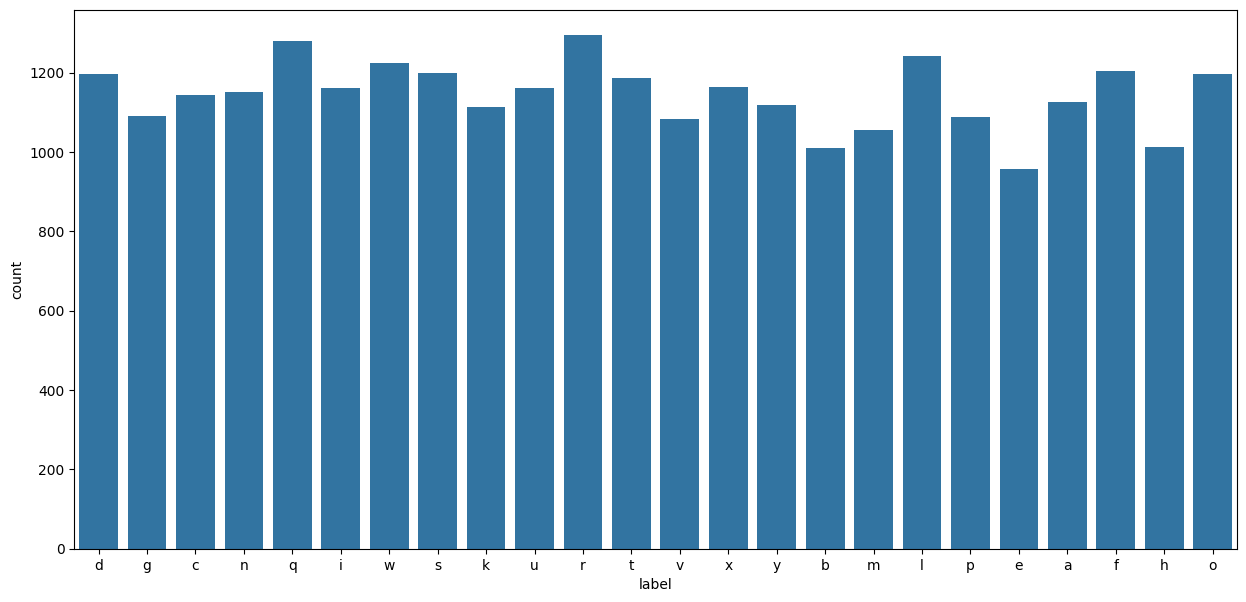

In [ ]:
# check class distribution
# convert to actual letters using dict
alpha_labels = train_df.label.apply(lambda x: alpha_dict[x])
sns.countplot(x=alpha_labels)
plt.show()

In [ ]:
# create custom pytorch dataset class
class SignDataset(Dataset) :
    def __init__(self, img, label) :
        self.classes = np.array(label)
        img = img / 255.0
        self.img = np.array(img).reshape(-1, 28, 28, 1)

        self.transform = T.Compose([
            T.ToTensor()
        ])

    def __len__(self) :
        return len(self.img)

    def __getitem__(self, index) :
        label = self.classes[index]
        img = self.img[index]
        img = self.transform(img)

        label = torch.LongTensor([label])
        img = img.float()

        return img, label

In [ ]:
# create datasets
train_set = SignDataset(train_df.drop('label', axis=1), train_df['label'])
test_set = SignDataset(test_df.drop('label', axis=1), test_df['label'])

In [ ]:
# show a single image
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Label: {dataset.classes[label]}\nAlpha Label: {alpha_dict[dataset.classes[label]]}")

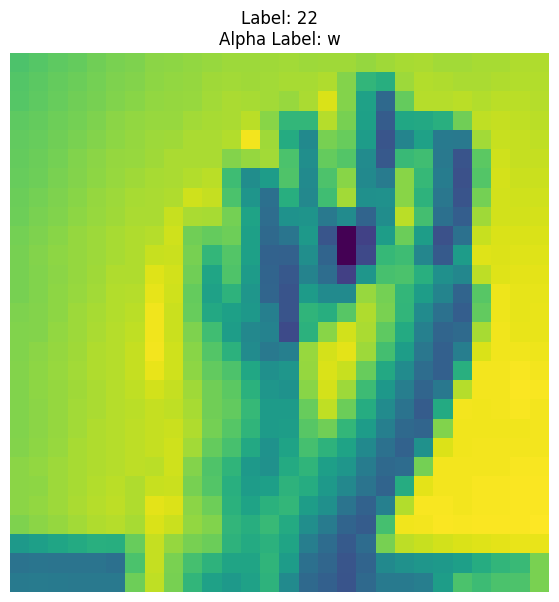

In [ ]:
show_image(*train_set[4], train_set)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)

In [ ]:
# visualize a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

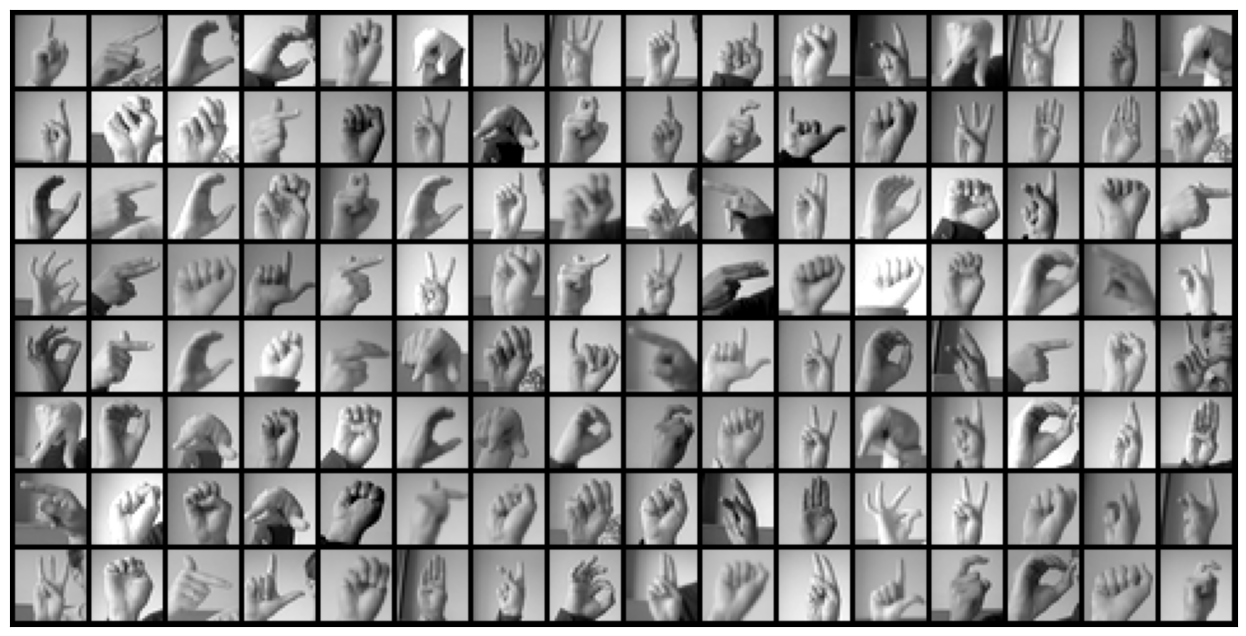

In [ ]:
# show a batch of images (128 images)
show_batch(train_dl)

In [ ]:
# convlutional block with batchnorm, max pooling and dropout
def conv_block(in_channels, out_channels, pool=False, drop=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if drop: layers.append(nn.Dropout())
    return nn.Sequential(*layers)

In [ ]:
# network architecture
class SignConvNet(nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 16)
        self.conv2 = conv_block(16, 32, pool=True)
        self.conv3 = conv_block(32, 64, pool=True, drop=True)
        self.fc =  nn.Sequential(*[
                        nn.Flatten(),
                        nn.Linear(7 * 7 * 64, out_classes)
                    ])

    def forward(self, img):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        return self.fc(img)

In [ ]:
# get number of classes
num_classes = len(alpha_dict)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create model, optim  and loss
model = SignConvNet(1, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# checkout model layer output shapes, and memory usage
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Dropout-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                   

In [ ]:
epochs = 10
losses = []
for epoch in range(epochs):
    # for custom progress bar
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        epoch_acc = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            data, target = data.to(device), target.to(device) # move input to GPU
            out = model(data)
            loss = criterion(out, target.squeeze())
            epoch_loss += loss.item()
            loss.backward()
            optim.step()
            optim.zero_grad()
            tepoch.set_postfix(loss = loss.item()) # show loss and per batch of data
    losses.append(epoch_loss)

Epoch 10: 100%|██████████| 215/215 [00:52<00:00,  4.10batch/s, loss=0.0173]


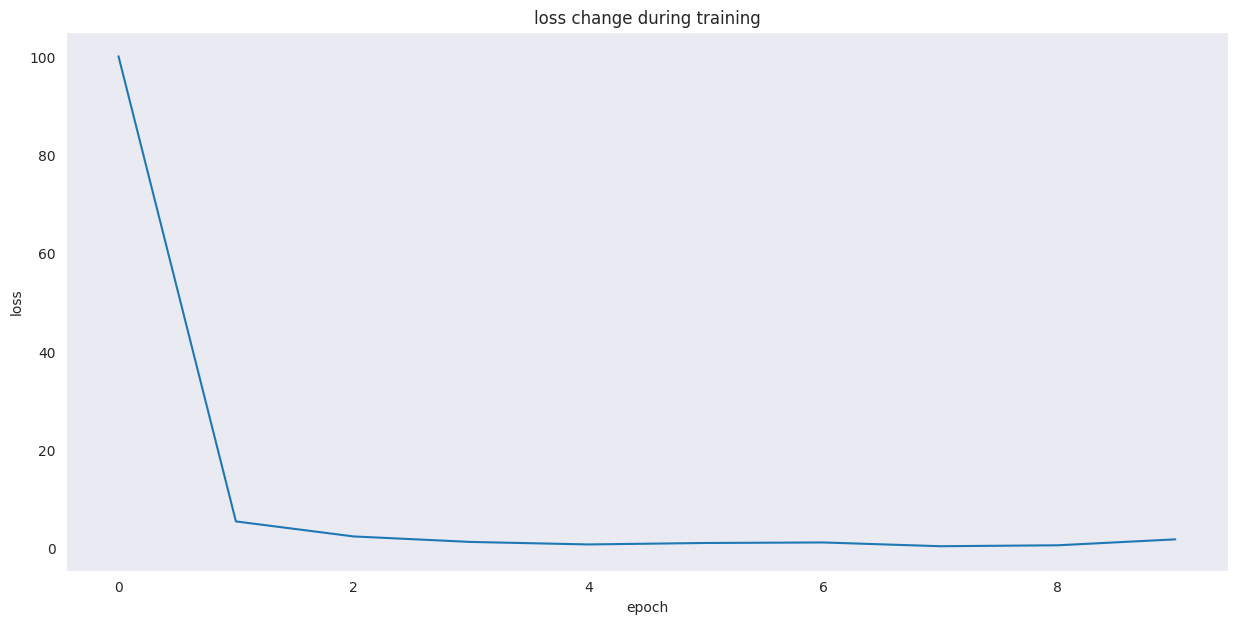

In [ ]:
# plot losses
sns.set_style("dark")
sns.lineplot(data=losses).set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.show()

In [ ]:
# predict on testing data samples (the accuracy here is batch accuracy)
y_pred_list = []
y_true_list = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

100%|██████████| 57/57 [00:09<00:00,  6.09batch/s]


In [ ]:
# flatten prediction and true lists
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])

print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 7172


In [ ]:
# calculate total testing accuracy
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 92.65%


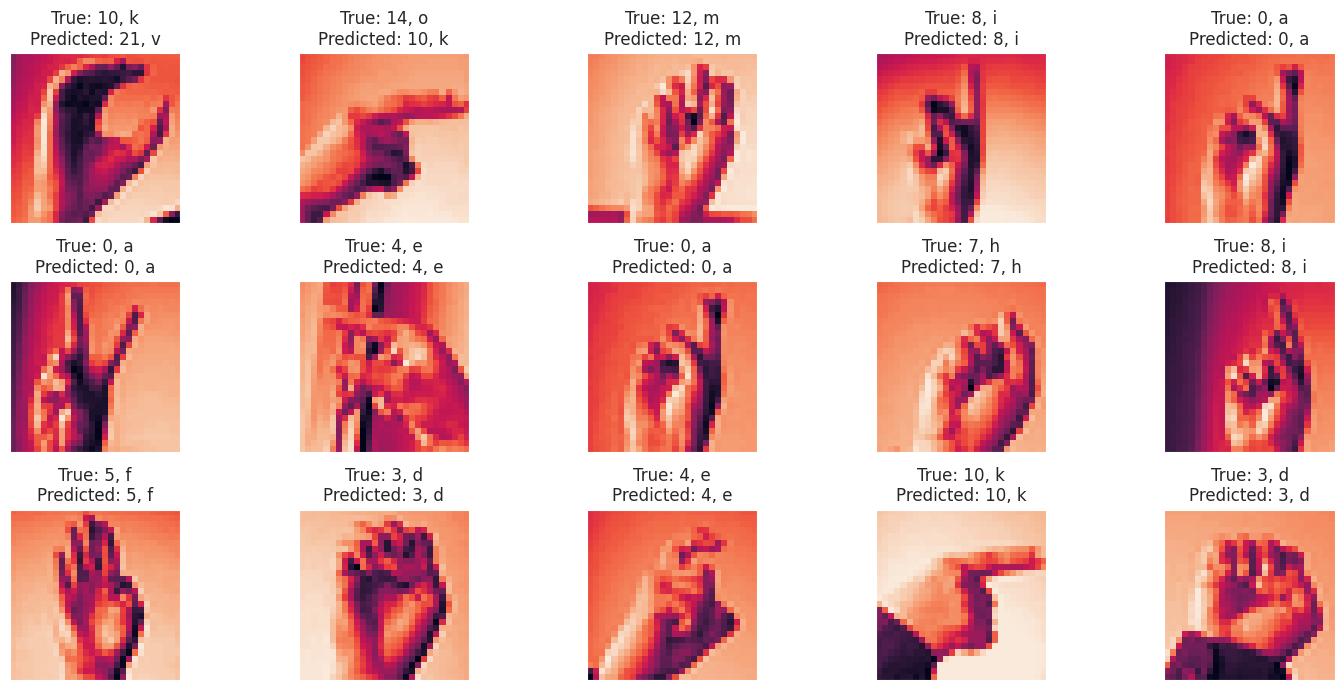

In [ ]:
# Display 15 random picture of the dataset with their labels
inds = np.random.randint(len(test_set), size=15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(inds, axes.flat):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    dict_real = alpha_dict[test_set.classes[label]]
    dict_pred = alpha_dict[test_set.classes[flat_pred[i]]]
    ax.set_title(f"True: {test_set.classes[label]}, {dict_real}\nPredicted: {test_set.classes[flat_pred[i]]}, {dict_pred}")
plt.tight_layout()
plt.show()

In [ ]:
# classification report
print(classification_report(flat_true, flat_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       331
           1       1.00      0.97      0.98       432
           2       1.00      0.97      0.98       310
           3       0.90      0.98      0.94       245
           4       0.98      0.98      0.98       498
           5       0.85      1.00      0.92       247
           6       0.92      0.93      0.92       348
           7       0.89      0.93      0.91       436
           8       1.00      0.88      0.93       288
          10       0.95      0.91      0.93       331
          11       0.89      0.99      0.94       209
          12       0.92      0.93      0.92       394
          13       0.82      0.80      0.81       291
          14       1.00      0.85      0.92       246
          15       0.99      1.00      0.99       347
          16       0.99      0.98      0.99       164
          17       0.72      0.87      0.79       144
          18       0.82    

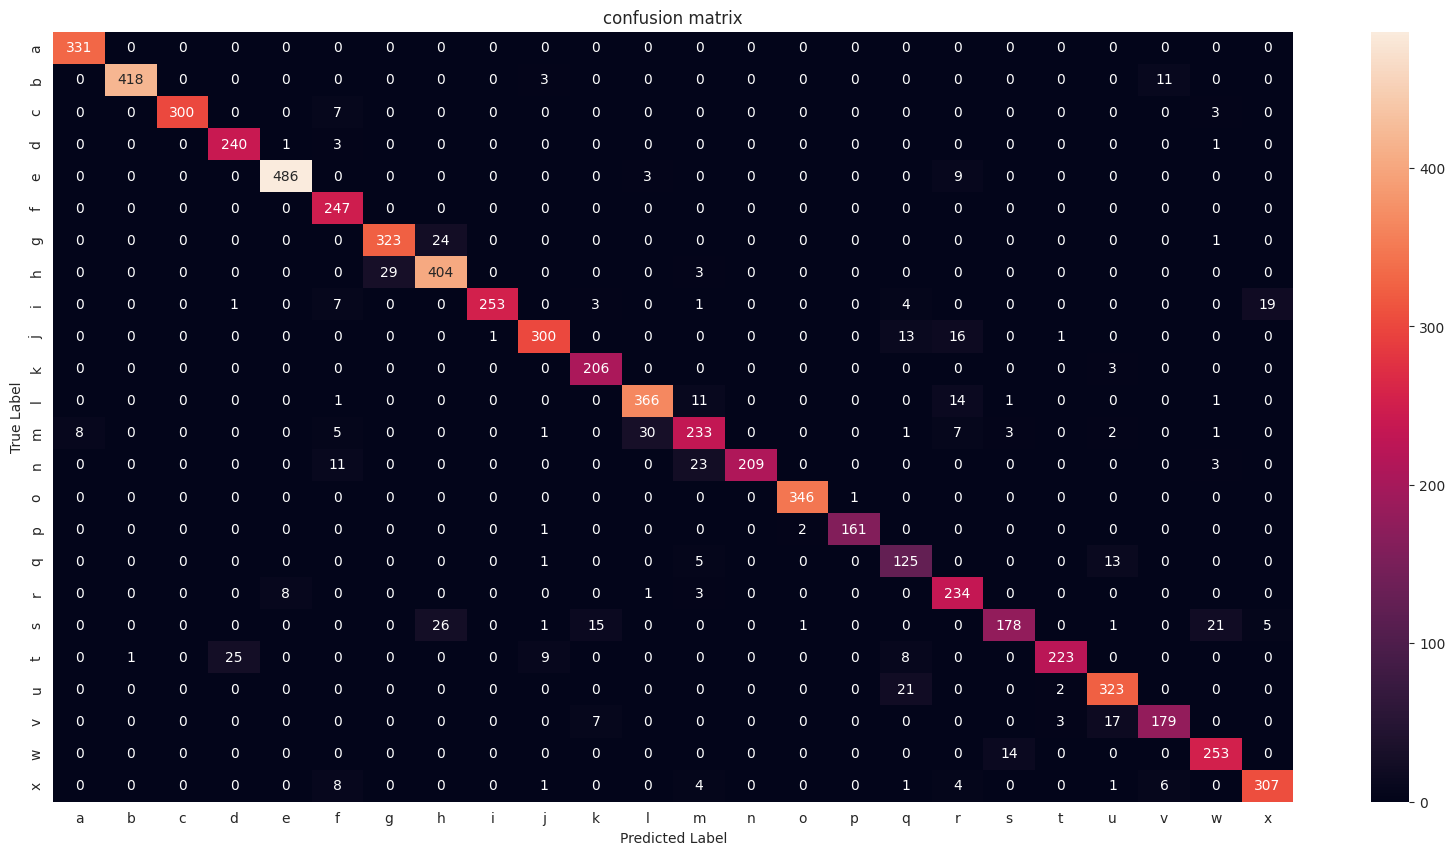

In [ ]:
# plot confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=alpha_dict, index=alpha_dict)
plt.figure(figsize=(20, 10))
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()